In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import shap

df = pd.read_csv("../../data/csv/cleaned_fix.csv")

2025-06-02 16:55:56.160195: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-02 16:55:56.169350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748876156.179769  350634 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748876156.183057  350634 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748876156.191224  350634 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
columns = ["Image", "Scene", "ROI", "FixDur", "FixNr", "Start", "End", "X", "Y"]
columns = ["Image", "Scene", "ROI", "FixDur", "Start", "End", "X", "Y"]


In [3]:
X = df[columns]
y = df.iloc[:, -1]   # last column as target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X_numeric = X.select_dtypes(include=['int64', 'float64'])  # Keep only numeric columns
X_scaled = StandardScaler().fit_transform(X_numeric)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(8,)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(32, activation='relu'),
    
    layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=500, batch_size=64, validation_split=0.1)

/home/sam/anaconda3/envs/tf310/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1748876157.688057  350634 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/500
340/340 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2576 - loss: 1.6542 - val_accuracy: 0.2663 - val_loss: 1.3813
Epoch 2/500
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2615 - loss: 1.4117 - val_accuracy: 0.2945 - val_loss: 1.3715
Epoch 3/500
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2654 - loss: 1.3948 - val_accuracy: 0.2820 - val_loss: 1.3708
Epoch 4/500
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2667 - loss: 1.3911 - val_accuracy: 0.2974 - val_loss: 1.3680
Epoch 5/500
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2754 - loss: 1.3813 - val_accuracy: 0.3061 - val_loss: 1.3661
Epoch 6/500
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2834 - loss: 1.3799 - val_accuracy: 0.3015 - val_loss: 1.3663
Epoch 7/500
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2835 - loss: 1.3782 - val_accuracy: 0.3015 - val_loss: 1.3663
Epoch 8/500
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2796 - loss: 1.3776 - val_accu

In [4]:
# SHAP needs background data (a small sample of training data)
explainer = shap.DeepExplainer(model, X_train[:100])
shap_values = explainer.shap_values(X_test[:100]) # shape: (samples, features)

for class_idx in range(4):
    print(f"\nTop features for class {label_encoder.classes_[class_idx]}")
    class_shap_values = np.abs(shap_values[:, :, class_idx]).mean(axis=0)
    top_features = pd.Series(class_shap_values, index=X.columns).sort_values(ascending=False)
    print(top_features)

/home/sam/anaconda3/envs/tf310/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/home/sam/anaconda3/envs/tf310/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(100, 8))']
  warnings.warn(msg)
/home/sam/anaconda3/envs/tf310/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(200, 8))']
  warnings.warn(msg)



Top features for class CSI
Scene     0.075837
Y         0.070735
ROI       0.061564
FixDur    0.047920
End       0.035582
Start     0.034417
X         0.029792
Image     0.024226
dtype: float64

Top features for class Control
Scene     0.062188
ROI       0.061700
Y         0.059853
FixDur    0.049035
End       0.038344
Start     0.035839
X         0.030115
Image     0.024836
dtype: float64

Top features for class FirstYear
ROI       0.137515
Y         0.088524
FixDur    0.086745
End       0.066110
Start     0.052484
Scene     0.050759
X         0.045526
Image     0.027065
dtype: float64

Top features for class ThirdYear
Y         0.119881
Scene     0.104850
ROI       0.070412
FixDur    0.066253
End       0.043522
Start     0.042695
X         0.037532
Image     0.026020
dtype: float64


In [5]:
model.evaluate(X_test, y_test)

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - accuracy: 0.3384 - loss: 1.3103


[1.3107737302780151, 0.33847686648368835]

In [6]:
# import matplotlib.pyplot as plt

# plt.plot(history.history['accuracy'], label='train acc')
# plt.plot(history.history['val_accuracy'], label='val acc')
# plt.legend()
# plt.show()


In [7]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"\nTest Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - accuracy: 0.3384 - loss: 1.3103

Test Loss: 1.3108, Test MAE: 0.3385


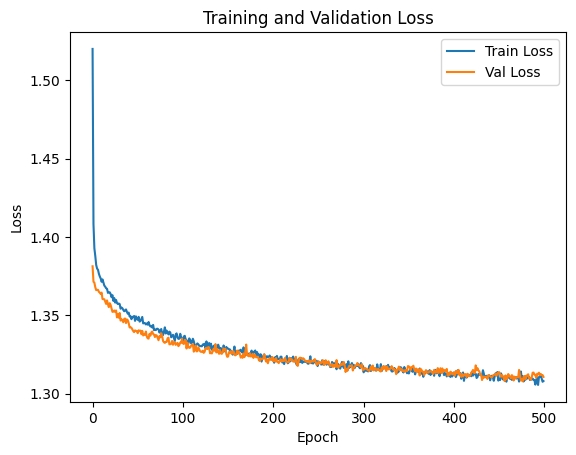

In [8]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step


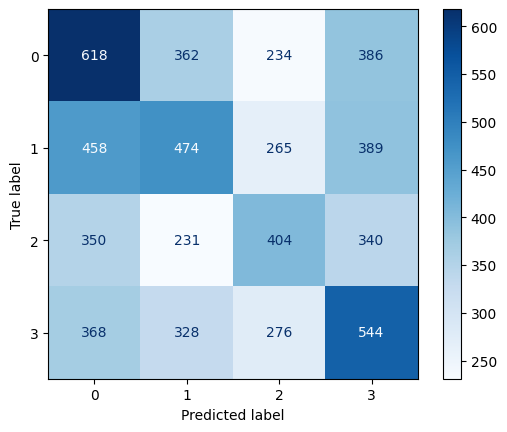

In [9]:
# No need to use np.argmax since y_test is already class indices
y_true = y_test
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Get predicted class indices

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

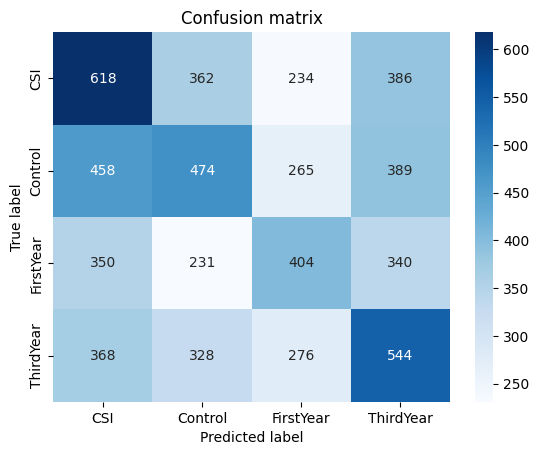

In [10]:
import seaborn as sns

sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

In [11]:
# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

         CSI       0.34      0.39      0.36      1600
     Control       0.34      0.30      0.32      1586
   FirstYear       0.34      0.30      0.32      1325
   ThirdYear       0.33      0.36      0.34      1516

    accuracy                           0.34      6027
   macro avg       0.34      0.34      0.34      6027
weighted avg       0.34      0.34      0.34      6027

